## Calculate utterance related features

In [38]:
import pandas as pd
from pathlib import Path

TRANSCRIPT_DIR = Path("transcript_files/")

# Load all transcript files
transcript_files = sorted(TRANSCRIPT_DIR.glob("*_TRANSCRIPT.csv"))
all_summaries = []

for file_path in transcript_files:
    try:
        # Split the fields by tab and skip the first row
        df = pd.read_csv(file_path, sep="\t", header=None, names=["start_time", "stop_time", "speaker", "value"]).iloc[1:]
        
        # Transform the start_time and stop_time to float
        df["start_time"] = df["start_time"].astype(float)
        df["stop_time"] = df["stop_time"].astype(float)
        df["duration"] = df["stop_time"] - df["start_time"]

        # Extract features
        summary = {
            "Participant_ID": int(file_path.stem.split("_")[0]),
            "Num_Utterances_Ellie": (df['speaker'] == 'Ellie').sum(),
            "Num_Utterances_Participant": (df['speaker'] == 'Participant').sum(),
            "Total_Duration_Ellie": df.loc[df['speaker'] == 'Ellie', 'duration'].sum(),
            "Total_Duration_Participant": df.loc[df['speaker'] == 'Participant', 'duration'].sum(),
            "Avg_Utterance_Duration_Ellie": df.loc[df['speaker'] == 'Ellie', 'duration'].mean(),
            "Avg_Utterance_Duration_Participant": df.loc[df['speaker'] == 'Participant', 'duration'].mean(),
        }

        speakers = df['speaker'].values
        
        # Calculate the number of conversational turns between Ellie and the Participant.
        # A turn is defined as a transition from Ellie speaking to the Participant speaking.
        summary['Num_Turns'] = sum((speakers[i] == 'Ellie' and speakers[i+1] == 'Participant') for i in range(len(speakers)-1))

        all_summaries.append(summary)

    except Exception as e:
        print(f"[!] Error processing {file_path.name}: {e}")

# Create a DataFrame from the summaries
utt_feature_df = pd.DataFrame(all_summaries)
utt_cols = utt_feature_df.columns[1:]

[!] Error processing ._487_TRANSCRIPT.csv: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte


In [39]:
utt_feature_df

,Participant_ID,Num_Utterances_Ellie,Num_Utterances_Participant,Total_Duration_Ellie,Total_Duration_Participant,Avg_Utterance_Duration_Ellie,Avg_Utterance_Duration_Participant,Num_Turns
0,300,87,87,140.840,155.760,1.618851,1.790345,58
1,301,77,104,97.950,475.440,1.272078,4.571538,49
2,302,89,97,113.393,208.933,1.274079,2.153948,53
3,303,88,103,148.230,642.930,1.684432,6.242039,57
4,304,100,104,164.100,362.600,1.641000,3.486538,75
...,...,...,...,...,...,...,...,...
184,488,64,138,135.227,422.490,2.112922,3.061522,39
185,489,85,117,163.259,168.810,1.920694,1.442821,67
186,490,77,97,149.917,185.900,1.946974,1.916495,51
187,491,85,146,163.156,413.580,1.919482,2.832740,58


In [40]:
utt_feature_df.describe()

,Participant_ID,Num_Utterances_Ellie,Num_Utterances_Participant,Total_Duration_Ellie,Total_Duration_Participant,Avg_Utterance_Duration_Ellie,Avg_Utterance_Duration_Participant,Num_Turns
count,189.000000,189.000000,189.000000,189.000000,189.000000,186.000000,189.000000,189.000000
mean,395.947090,79.359788,171.433862,138.837915,465.619868,1.783299,2.766578,56.423280
std,56.117822,17.626071,75.070549,28.262670,235.769867,0.293228,0.979835,13.436244
min,300.000000,0.000000,42.000000,0.000000,62.230000,1.031296,1.131455,0.000000
25%,348.000000,71.000000,118.000000,127.778000,295.760000,1.500038,2.119902,49.000000
50%,396.000000,80.000000,155.000000,142.310000,430.920000,1.888965,2.581485,56.000000
75%,444.000000,89.000000,211.000000,154.646000,591.390000,2.009469,3.296306,64.000000
max,492.000000,121.000000,386.000000,214.678000,1282.820000,2.303188,7.215654,99.000000


### Sessions with special notes:
- 373 – there is an interruption around 5:52-7:00, the confederate enters the room to fix a minor 
technical issue, the session continuous and completes . 
- 444 – there is an interruption around 4:46-6:27, the participant’s phone rings and the 
confederate enters the room to help them turn it off. Session continuous and completes. 
- 451, 458, 480 – sessions are technically complete, but missing Ellie (the virtual human) part of the 
transcripts. Participant transcripts are still included, but without the interviewer questions.
- 402 – video recording is cut ~2min before the end of the conversation. 

## Merge with split data containing demographic and label information

In [41]:
CWD = Path("downloads/")

train = pd.read_csv(CWD / "train_split_Depression_AVEC2017.csv")
dev = pd.read_csv(CWD / "dev_split_Depression_AVEC2017.csv")
# test = pd.read_csv(CWD / "test_split_Depression_AVEC2017.csv")

test = pd.read_csv(CWD / "full_test_split.csv")
test.rename(columns={"PHQ_Score": "PHQ8_Score", "PHQ_Binary": "PHQ8_Binary"}, inplace=True)

In [42]:
# Add a 'split' column to each dataframe
train['Split'] = 'train'
dev['Split'] = 'dev'
test['Split'] = 'test'

# Concatenate the dataframes
combined_df = pd.concat([train, dev, test])

# Sort by Participant_ID
combined_df = combined_df.sort_values(by='Participant_ID').reset_index(drop=True)

# Reorder columns
use_cols = ['Split', 'Participant_ID', 'Gender', 'PHQ8_Binary', 'PHQ8_Score']
columns_order = use_cols + [col for col in combined_df.columns if col not in use_cols]
combined_df = combined_df[columns_order]

combined_df

,Split,Participant_ID,Gender,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,test,300,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,test,301,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dev,302,1,0,4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,train,303,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train,304,0,0,6,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,train,488,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,dev,489,1,0,3,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
186,dev,490,1,0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
187,train,491,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [43]:
# Merge combined_df and utt_feature_df on Participant_ID
merged_df = pd.merge(combined_df, utt_feature_df, on='Participant_ID', how='inner')

# Display the merged dataframe
merged_df

,Split,Participant_ID,Gender,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Num_Utterances_Ellie,Num_Utterances_Participant,Total_Duration_Ellie,Total_Duration_Participant,Avg_Utterance_Duration_Ellie,Avg_Utterance_Duration_Participant,Num_Turns
0,test,300,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,87,140.840,155.760,1.618851,1.790345,58
1,test,301,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,104,97.950,475.440,1.272078,4.571538,49
2,dev,302,1,0,4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,89,97,113.393,208.933,1.274079,2.153948,53
3,train,303,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88,103,148.230,642.930,1.684432,6.242039,57
4,train,304,0,0,6,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,100,104,164.100,362.600,1.641000,3.486538,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,train,488,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,138,135.227,422.490,2.112922,3.061522,39
185,dev,489,1,0,3,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,85,117,163.259,168.810,1.920694,1.442821,67
186,dev,490,1,0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,77,97,149.917,185.900,1.946974,1.916495,51
187,train,491,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,85,146,163.156,413.580,1.919482,2.832740,58


In [44]:
# Define the full range of Participant_IDs
full_range = set(range(300, 493))

# Find missing Participant_IDs
missing_ids = full_range - set(merged_df['Participant_ID'])
print("Missing Participants (Excluded sessions):", sorted(missing_ids))

Missing Participants (Excluded sessions): [342, 394, 398, 460]


In [45]:
# Drop the specified columns from combined_df
columns_to_drop = ['PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 
                   'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']
df = merged_df.drop(columns=columns_to_drop)

# Create the 'data' folder if it doesn't exist
Path("data").mkdir(exist_ok=True)

# Save the DataFrame as a CSV file in the 'data' folder
df.to_csv("data/df.csv", index=False)

In [46]:
print("Gender value counts:")
print(df['Gender'].value_counts())

print("\nPHQ8_Binary value counts:")
print(df['PHQ8_Binary'].value_counts())

Gender value counts:
Gender
1    102
0     87
Name: count, dtype: int64

PHQ8_Binary value counts:
PHQ8_Binary
0    133
1     56
Name: count, dtype: int64


In [47]:
print(df.loc[df['Split']=='train'][['Gender', 'PHQ8_Binary']].value_counts())

Gender  PHQ8_Binary
1       0              50
0       0              27
        1              17
1       1              13
Name: count, dtype: int64


- Gender: {0: Female, 1: Male}
- PHQ8_Binary: {0: Not depressed (ND), 1: Depressed (D)}

## Simple EDA

C:\Users\gyuna\AppData\Local\Temp\ipykernel_26548\3147850900.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='PHQ8_Binary', palette='pastel')


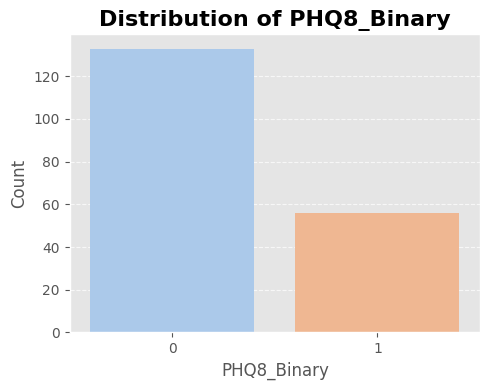

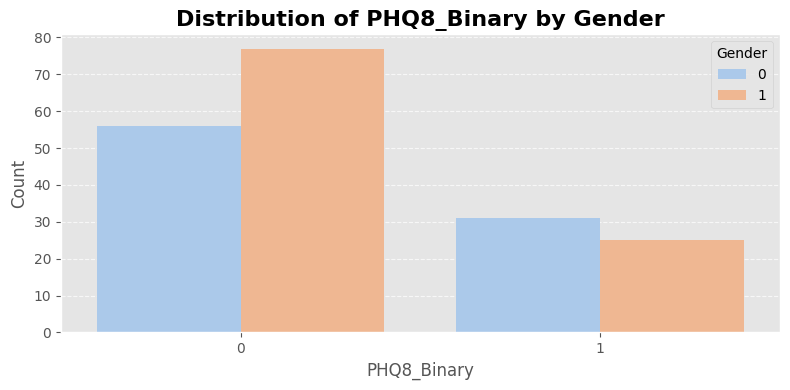

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='PHQ8_Binary', palette='pastel')
plt.title("Distribution of PHQ8_Binary", fontsize=16, fontweight='bold')
plt.xlabel("PHQ8_Binary", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='PHQ8_Binary', hue='Gender', palette='pastel')
plt.title("Distribution of PHQ8_Binary by Gender", fontsize=16, fontweight='bold')
plt.xlabel("PHQ8_Binary", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\gyuna\AppData\Local\Temp\ipykernel_26548\3616020619.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', palette='pastel')


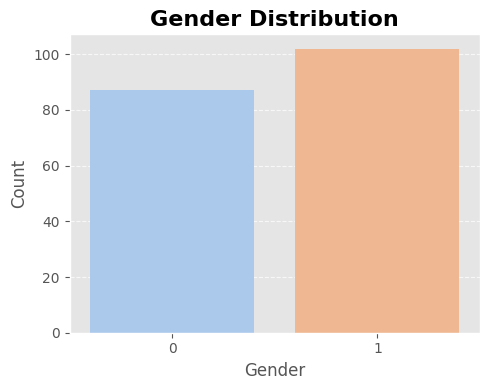

In [49]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='Gender', palette='pastel')
plt.title("Gender Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

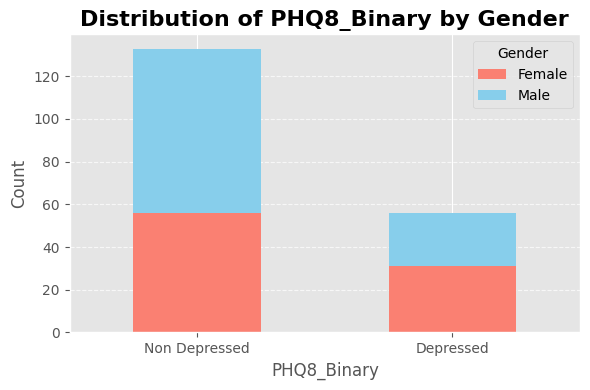

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a stacked bar chart for the distribution of PHQ8_Binary by Gender
df_grouped = df.groupby(['PHQ8_Binary', 'Gender']).size().unstack(fill_value=0)

df_grouped.plot(kind='bar', stacked=True, figsize=(6, 4), color=['salmon', 'skyblue'])
plt.title("Distribution of PHQ8_Binary by Gender", fontsize=16, fontweight='bold')
plt.xlabel("PHQ8_Binary", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Non Depressed", "Depressed"], fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.legend(title="Gender", labels=["Female", "Male"], fontsize=10) # 0: Female, 1: Male
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot(data, columns, title, hue=None):
    """
    Plots a boxplot for the specified columns in the DataFrame.

    Parameters:
    - data (DataFrame): A pandas DataFrame containing the data to plot.
    - columns (list): A list of column names to include in the boxplot.
    - title (str): The title of the plot.
    """
    if hue is None:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=data[columns], palette="pastel")
    else:
        # Melt the dataframe to long format for seaborn
        melted_data = data.melt(id_vars=hue, value_vars=columns, var_name="Feature", value_name="Value")
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=melted_data, x="Feature", y="Value", hue=hue, palette="pastel")
        
    plt.title(title)
    plt.show()

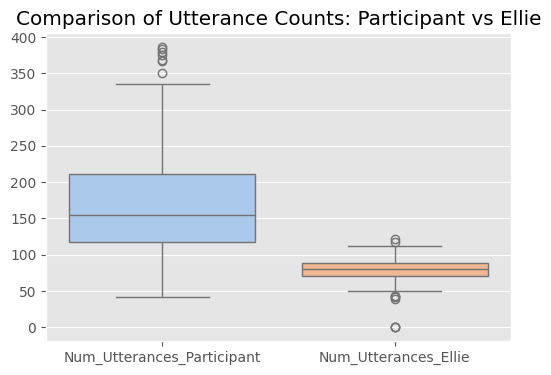

In [52]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie")

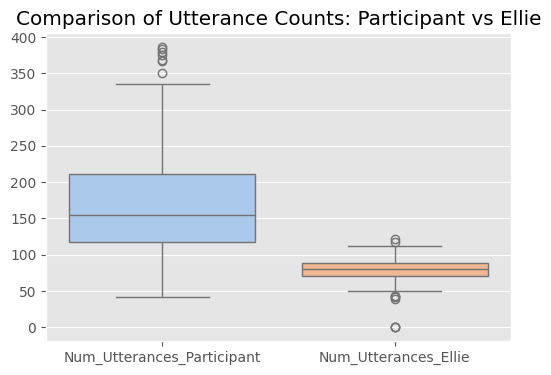

In [53]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie")

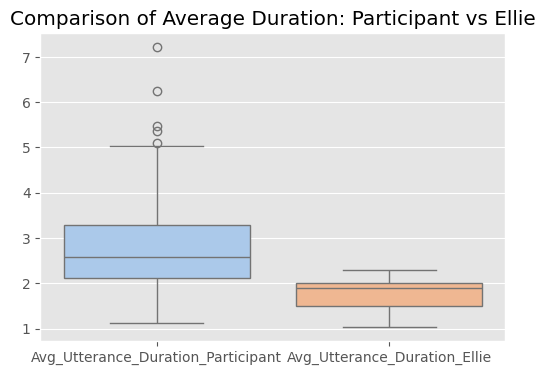

In [54]:
plot_boxplot(df,
             columns=['Avg_Utterance_Duration_Participant', 'Avg_Utterance_Duration_Ellie'],
             title="Comparison of Average Duration: Participant vs Ellie")

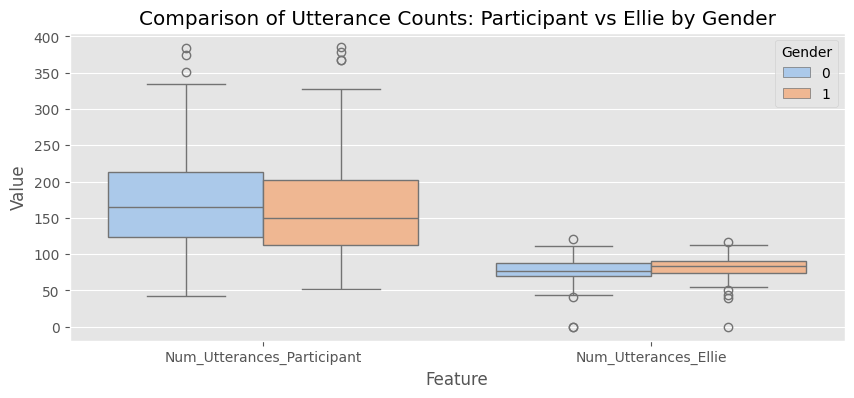

In [55]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie by Gender",
             hue='Gender')

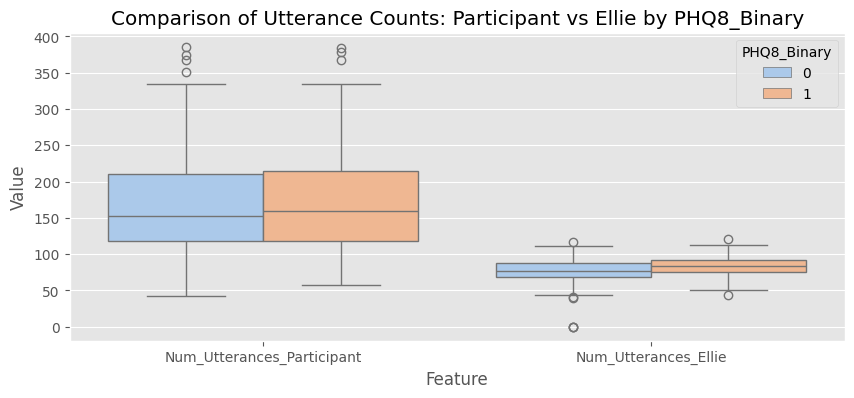

In [56]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie by PHQ8_Binary",
             hue='PHQ8_Binary')

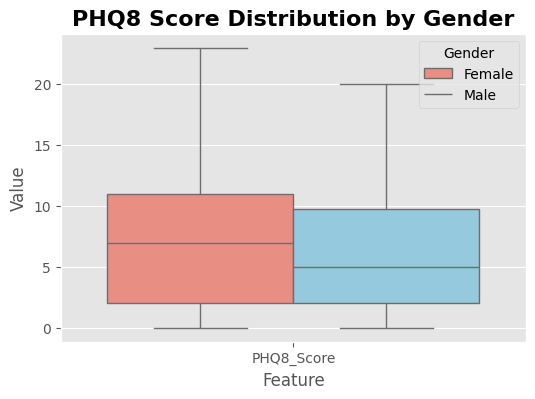

In [57]:
plt.figure(figsize=(6, 4))
melted_data = df.melt(id_vars='Gender', value_vars=['PHQ8_Score'], var_name="Feature", value_name="Value")
sns.boxplot(data=melted_data, x="Feature", y="Value", hue='Gender', palette=['salmon', 'skyblue'])

plt.title("PHQ8 Score Distribution by Gender", fontsize=16, fontweight='bold')
plt.legend(title="Gender", labels=["Female", "Male"], fontsize=10)  # 0: Female, 1: Male
plt.show()

## Visualization

In [ ]:
import os
from pathlib import Path
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.style.use("ggplot")

WAV_DIR = Path("wav_files")

from matplotlib.ticker import FuncFormatter

def seconds_to_minsec(x, pos):
    minutes = int(x) // 60
    seconds = int(x) % 60
    return f"{minutes}:{seconds:02d}"


def load_audio(uid: str, sr_target=16000, max_duration=None):
    wav_path = WAV_DIR / f"{uid}_AUDIO.wav"
    if max_duration is not None:
        y, sr = librosa.load(wav_path, sr=sr_target, duration=max_duration)
    else:
        y, sr = librosa.load(wav_path, sr=sr_target)
    return y, sr

def plot_audio(uid: str, gender: str, label: str):
    y, sr = load_audio(uid)
    t = np.linspace(0, len(y) / sr, num=len(y))

    n_fft = 1024
    hop_length = 512
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    fig = plt.figure(figsize=(16, 6))
    gs = GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.4)

    # ▶ 1행: waveform 
    ax0 = fig.add_subplot(gs[0, 0])  # row 0, col 0
    ax0.plot(t, y, color="tomato", linewidth=0.8)
    ax0.set_title("Waveform")
    ax0.set_ylabel("Amplitude")
    ax0.set_xlim([0, t[-1]])
    ax0.xaxis.set_major_formatter(FuncFormatter(seconds_to_minsec))

    # ▶ 2행: spectrogram 
    ax1 = fig.add_subplot(gs[1, 0])  # row 1, col 0
    img = librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                                   x_axis='time', y_axis='hz', cmap='viridis', ax=ax1)
    ax1.set_title("Log Spectrogram")
    ax1.set_xlabel("Time (min:sec)")
    ax1.set_ylabel("Frequency (Hz)")

    # ▶ Colorbar 따로 오른쪽 col=1에 위치
    cax = fig.add_subplot(gs[1, 1])  # row 1, col 1
    cbar = fig.colorbar(img, cax=cax, format="%+2.0f dB")
    cbar.set_label("dB")

    if gender is not None and label is not None:
        gender = "Female" if gender == 0 else "Male"
        label = "ND" if label == 0 else "D"
        fig.suptitle(f"PID: {uid} - {gender}, {label}", fontsize=15)
    else:
        fig.suptitle(f"PID: {uid} - Audio Visualization", fontsize=15)
    plt.tight_layout()
    plt.show()

C:\Users\gyuna\AppData\Local\Temp\ipykernel_26548\655983241.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


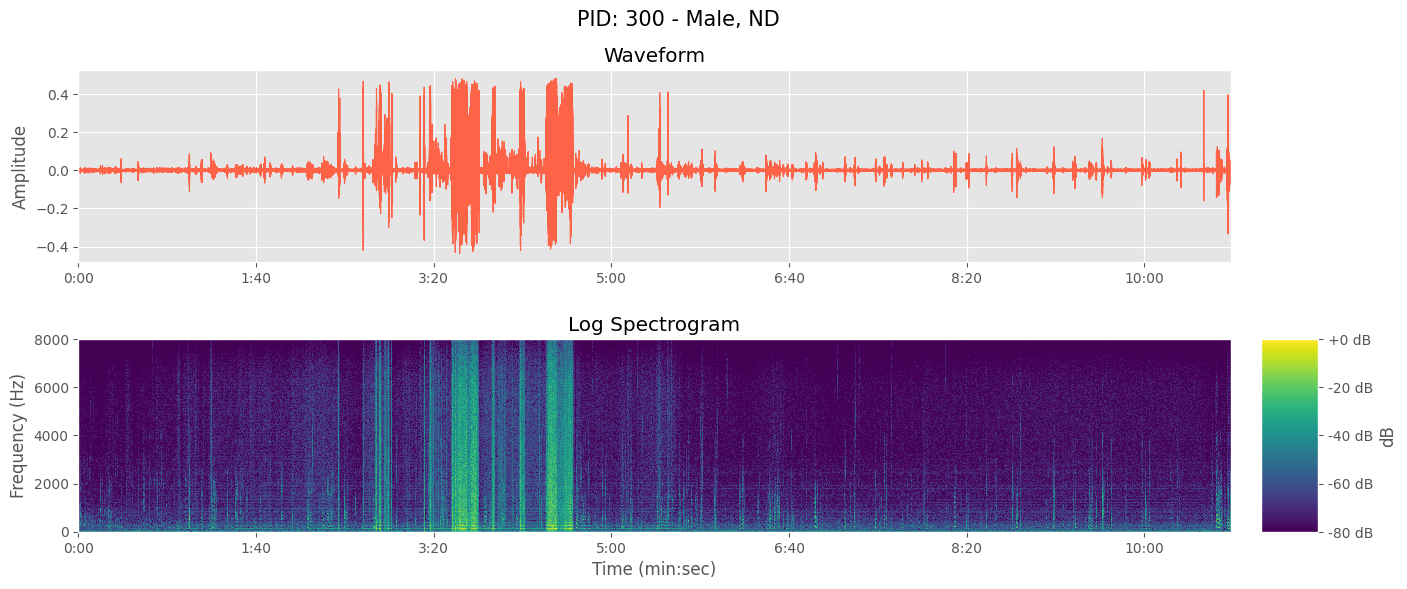

In [66]:
PID = 300

participant_data = df.loc[df['Participant_ID'] == PID]
gender = participant_data['Gender'].values[0]
phq8_binary = participant_data['PHQ8_Binary'].values[0]

plot_audio(PID, gender, phq8_binary)

C:\Users\gyuna\AppData\Local\Temp\ipykernel_26548\655983241.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


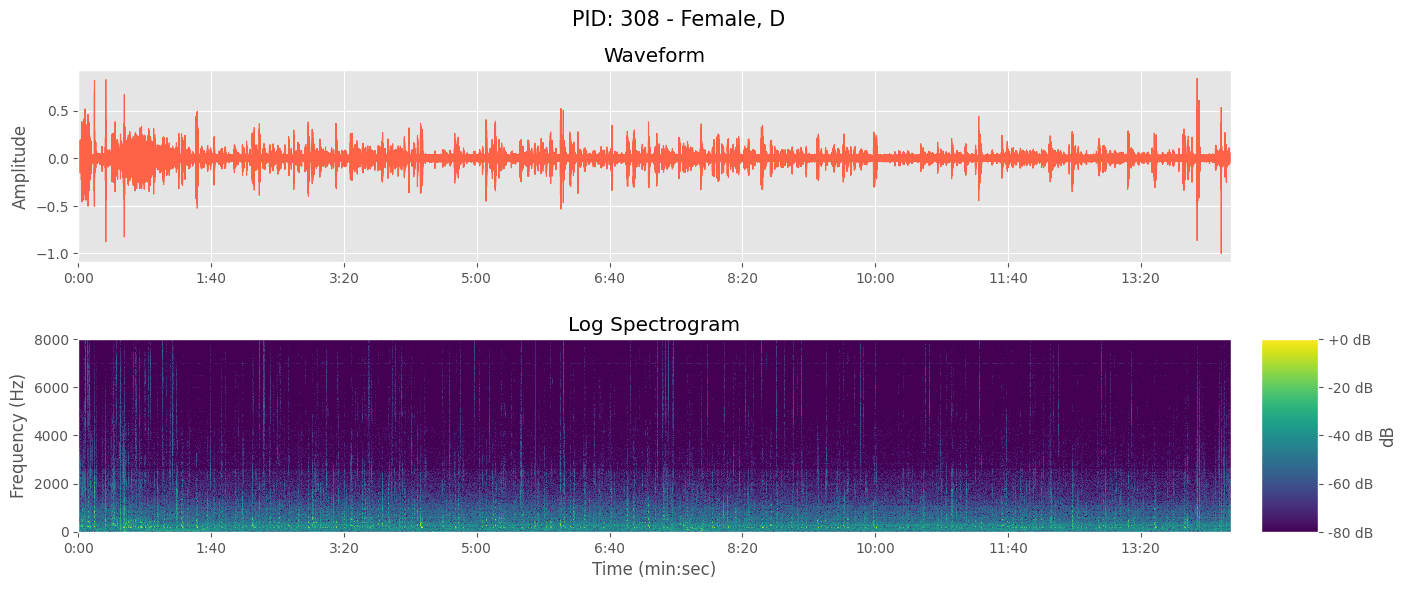

In [67]:
PID = 308

participant_data = df.loc[df['Participant_ID'] == PID]
gender = participant_data['Gender'].values[0]
phq8_binary = participant_data['PHQ8_Binary'].values[0]

plot_audio(PID, gender, phq8_binary)